# LSTM XOR
We want to implement an LSTM-RNN in TF to predict the XOR operation over a sequence of fixed length (for now) of bits.
First we need to generate these sequences and to compute the XOR itself.

Remarks:
- The XOR operation has a non-linear decision hyperplane

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

## Generating sequences
We generate a dataset of N sequences of length L. These sequences are bit strings.
We also compute the XOR of the sequence directly. 

In [65]:
LENGTH = 8
TRAIN_SAMPLES = 64
TEST_SAMPLES = 64

def xor(seq):
    return int(sum(seq) % 2 == 1)

Xtrain, Ytrain, Xtest, Ytest = [], [], [], []
for i in range(TRAIN_SAMPLES):
    seq = np.random.randint(0,2,LENGTH)
    Xtrain.append(seq)
    Ytrain.append(xor(seq))
for i in range(TEST_SAMPLES):
    seq = np.random.randint(0,2,LENGTH)
    Xtest.append(seq)
    Ytest.append(xor(seq))

## Building the model
Now we want to build a model which is able to compute the XOR of the sequence using an LSTM-RNN.

In [72]:
tf.reset_default_graph()

input_sequence = tf.placeholder(tf.float32, shape=(None, LENGTH))
input_sequence_3d = tf.reshape(input_sequence, (-1, LENGTH, 1))
results = tf.placeholder(tf.uint8, shape=(None, ))
results_oh = tf.one_hot(results, 2)
lstm = tf.contrib.rnn.BasicLSTMCell(2)

outputs, states = tf.nn.dynamic_rnn(lstm, input_sequence_3d, dtype=tf.float32)

final_output = tf.layers.dense(outputs, 2)[:, -1]
predictions = tf.argmax(final_output, axis=1)

loss = tf.losses.softmax_cross_entropy(results_oh, final_output)
train_op = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [73]:
BATCH_SIZE = 8

train_acc = []
test_acc = []
losses = []
for epoch in tnrange(500):
    _losses = []
    for batch_index in range(0, len(Xtrain), BATCH_SIZE):
        Xbatch = Xtrain[batch_index:batch_index + BATCH_SIZE]
        Ybatch = Ytrain[batch_index:batch_index + BATCH_SIZE]
        _loss, _fout, _ = sess.run([loss, final_output, train_op], feed_dict={input_sequence: Xbatch, results: Ybatch})
        _losses.append(_loss)
    losses.append(np.mean(_losses))
    acc = 0
    for batch_index in range(0, len(Xtrain), BATCH_SIZE):
        preds = sess.run(predictions, feed_dict={input_sequence: Xtrain[batch_index:batch_index+BATCH_SIZE]})
        acc += sum(abs(preds - Ytrain[batch_index:batch_index+BATCH_SIZE]))
    train_acc.append(1 - (acc / len(Xtrain)))
    acc = 0
    for batch_index in range(0, len(Xtest), BATCH_SIZE):
        preds = sess.run(predictions, feed_dict={input_sequence: Xtest[batch_index:batch_index+BATCH_SIZE]})
        acc += sum(abs(preds - Ytest[batch_index:batch_index+BATCH_SIZE]))
    test_acc.append(1 - (acc / len(Xtest)))

We can plot the results of the training and testing, along with the loss of the network

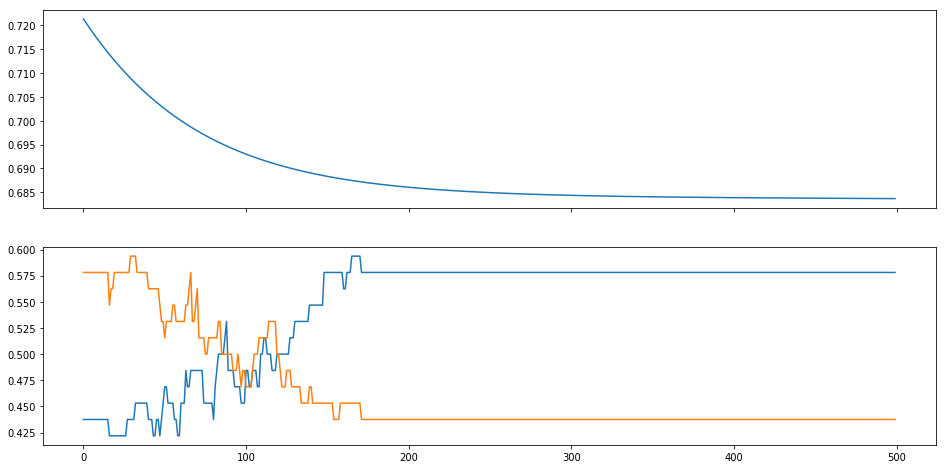

In [74]:
f, ax = plt.subplots(2, figsize=(16,8), sharex=True)
ax[0].plot(losses)
ax[1].plot(train_acc)
ax[1].plot(test_acc)
plt.show()

## Complete sequences
Instead of providing the network with the whole input sequence but only the XOR on the last step, we now provide the XOR result at each timestep. To do this, we need to generate also the sequence of XOR results.

In [87]:
LENGTH = 4
TRAIN_SAMPLES = 64
TEST_SAMPLES = 64

def xor(seq):
    return int(sum(seq) % 2 == 1)

Xtrain, Ytrain, Xtest, Ytest = [], [], [], []
for i in range(TRAIN_SAMPLES):
    seq = np.random.randint(0,2,LENGTH)
    xor_seq = [xor(seq[:i]) for i in range(1, len(seq)+1)]
    Xtrain.append(seq)
    Ytrain.append(xor_seq)
for i in range(TEST_SAMPLES):
    seq = np.random.randint(0,2,LENGTH)
    xor_seq = [xor(seq[:i]) for i in range(1, len(seq)+1)]
    Xtest.append(seq)
    Ytest.append(xor_seq)

## Network structure with whole-sequence

In [147]:
tf.reset_default_graph()

input_sequence = tf.placeholder(tf.float32, shape=(None, LENGTH))
input_sequence_3d = tf.reshape(input_sequence, (-1, LENGTH, 1))
results = tf.placeholder(tf.uint8, shape=(None, LENGTH))
results_oh = tf.one_hot(results, 2)
oh_reshaped = tf.reshape(results_oh, (-1, 2))
lstm = tf.contrib.rnn.BasicLSTMCell(2)

outputs, states = tf.nn.dynamic_rnn(lstm, input_sequence_3d, dtype=tf.float32)

final_output = tf.layers.dense(outputs, 2)
fo_reshaped = tf.reshape(final_output, shape=(-1, 2))
predictions = tf.argmax(final_output, axis=2)

loss = tf.losses.softmax_cross_entropy(oh_reshaped, fo_reshaped)
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [151]:
Xbatch = Xtrain[:2]
Ybatch = Ytrain[:2]
print(Xbatch, Ybatch)
for i in range(100):
    _ = sess.run(train_op, feed_dict={input_sequence: Xbatch, results: Ybatch})
_ = sess.run(fo_reshaped, feed_dict={input_sequence: Xbatch, results: Ybatch})
print(_)
_ = sess.run(oh_reshaped, feed_dict={input_sequence: Xbatch, results: Ybatch})
print(_)

[array([1, 1, 1, 1]), array([0, 0, 1, 1])] [[1, 0, 1, 0], [0, 0, 1, 0]]
[[ 0.21953556 -0.17365201]
 [ 0.25428304 -0.17606123]
 [ 0.2779859  -0.17665973]
 [ 0.29440364 -0.17634527]
 [ 0.20707875 -0.16946083]
 [ 0.23928964 -0.17074552]
 [ 0.2545267  -0.1731125 ]
 [ 0.2788775  -0.17451249]]
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
BATCH_SIZE = 8

train_acc = []
test_acc = []
losses = []
for epoch in tnrange(10):
    _losses = []
    for batch_index in range(0, len(Xtrain), BATCH_SIZE):
        Xbatch = Xtrain[batch_index:batch_index + BATCH_SIZE]
        Ybatch = Ytrain[batch_index:batch_index + BATCH_SIZE]
        _loss, _fout, _ = sess.run([loss, final_output, train_op], feed_dict={input_sequence: Xbatch, results: Ybatch})
        _losses.append(_loss)
    losses.append(np.mean(_losses))
    acc = 0
    for batch_index in range(0, len(Xtrain), BATCH_SIZE):
        preds = sess.run(predictions, feed_dict={input_sequence: Xtrain[batch_index:batch_index+BATCH_SIZE]})
        acc += sum(abs(preds - Ytrain[batch_index:batch_index+BATCH_SIZE]))
    train_acc.append(1 - (acc / len(Xtrain)))
    acc = 0
    for batch_index in range(0, len(Xtest), BATCH_SIZE):
        preds = sess.run(predictions, feed_dict={input_sequence: Xtest[batch_index:batch_index+BATCH_SIZE]})
        acc += sum(abs(preds - Ytest[batch_index:batch_index+BATCH_SIZE]))
    test_acc.append(1 - (acc / len(Xtest)))